In [2]:
# https://www.cs.toronto.edu/~kriz/cifar.html
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [4]:
files = unpickle('./data/data_batch_1')
files.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [5]:
data = files[b'data']
labels = files[b'labels']

In [6]:
data.shape

(10000, 3072)

In [7]:
data = data.reshape(10000, 3, 32, 32)
data.shape

(10000, 3, 32, 32)

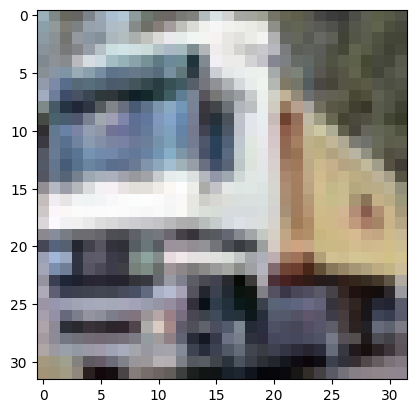

In [8]:
imshow(data[1])

In [9]:
labels[1]

9

In [10]:
classes[labels[1]]

'truck'

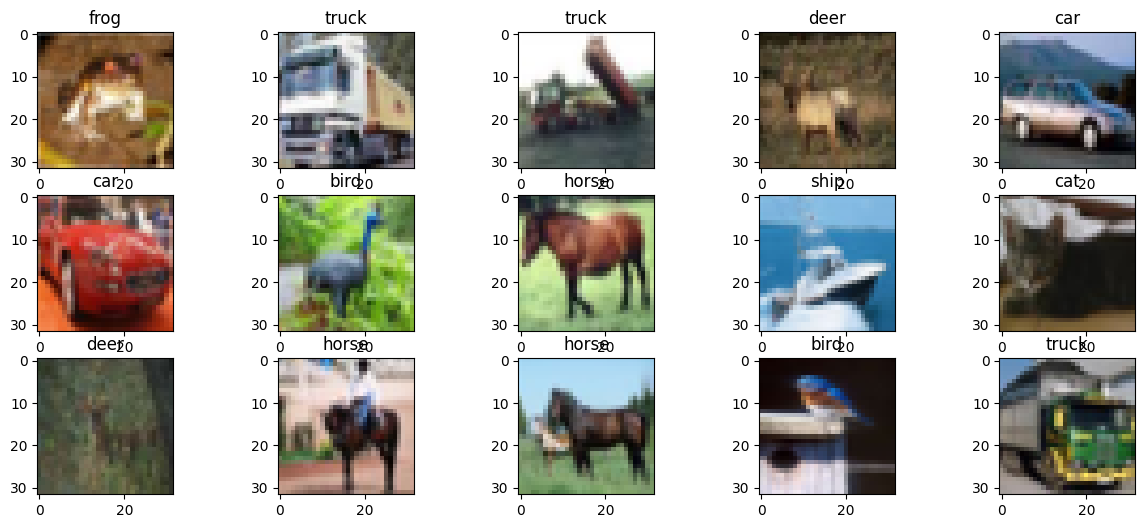

In [11]:
fig, ax = plt.subplots(3, 5, figsize=(15, 6))
idx=0
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(data[idx].transpose(1, 2, 0))
        ax[i, j].set_title(classes[labels[idx]])
        idx += 1

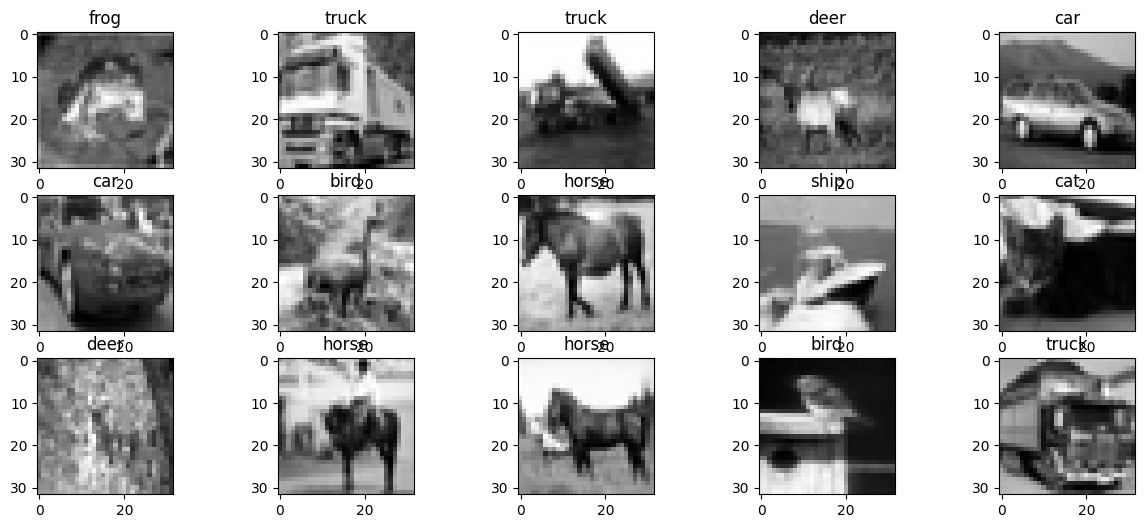

In [12]:
# convert to grayscale
data_gray = np.mean(data, axis=1)
data_gray.shape

idx = 0
fig, ax = plt.subplots(3, 5, figsize=(15, 6))
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(data_gray[idx], cmap='gray')
        ax[i, j].set_title(classes[labels[idx]])
        idx += 1

In [13]:
# merge data_gray and labels
data_gray = data_gray.reshape(10000, 32*32)
print(data_gray.shape)

data_gray = np.hstack((data_gray, np.array(labels).reshape(10000, 1)))
print(data_gray.shape)

# shuffle data
np.random.shuffle(data_gray)
print(data_gray.shape)

# split into train and test
train_data = data_gray[:8000, :-1]
train_labels = data_gray[:8000, -1]
test_data = data_gray[8000:, :-1]
test_labels = data_gray[8000:, -1]

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

(10000, 1024)
(10000, 1025)
(10000, 1025)


((8000, 1024), (8000,), (2000, 1024), (2000,))

# Building the model

Ã¼berlegungen: 32*32 -> 1024 Neuronen als Eingangswert

128 Neuronen in der ersten Schicht

128 Neuronen in der zweiten Schicht

10 Neuronen in der letzten Schicht als Ausgangswert

In [14]:
# convert to torch tensors
train_data = torch.tensor(train_data).float()
train_labels = torch.tensor(train_labels).long()
test_data = torch.tensor(test_data).float()
test_labels = torch.tensor(test_labels).long()

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

(torch.Size([8000, 1024]),
 torch.Size([8000]),
 torch.Size([2000, 1024]),
 torch.Size([2000]))

In [21]:
# define a convolutional neural network with 2 convolutional layers and 2 fully connected layers
class MyCNN(torch.nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32*8*8, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 32*8*8)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x